# Quadratic Programming

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8")

# Create synthetic data
ts = np.arange(0, 10, 0.1)
k_true = 0.25  # True value of k
r = 3  # Reference
xs = r * (1 - np.exp(-k_true * ts))

# Add noise
sigma = 0.3
noise = sigma * np.random.randn(len(ts))
ys = xs + noise

## Moving Horizon Estimate

In [2]:
import pyomo.environ as pyo

horizon_length = 20  # Horizon length for the MHE


def solve_mhe(ts: np.ndarray, y_obs: np.ndarray, horizon_start: int) -> (float, float):
    """Given a time horizon and observed data, solve the MHE problem"""
    model = pyo.ConcreteModel()

    horizon_end = horizon_start + horizon_length
    model.i = pyo.RangeSet(horizon_start, horizon_end - 1)

    model.x = pyo.Var(model.i)  # x at each time step in the horizon
    model.k = pyo.Var()  # Parameter to estimate

    # Minimize the sum of squared differences between 
    # the observed data and the estimated data
    def squared_error(m):
        return sum((y_obs[i + 1] - m.x[i]) ** 2 for i in model.i)

    model.objective = pyo.Objective(rule=squared_error, sense=pyo.minimize)

    # Add the model dynamics as a constraint
    def dynamics(m, i):
        # Skip the last time step to avoid an index error
        if i < horizon_end - 1:
            dt = ts[i + 1] - ts[i]
            return m.x[i + 1] == m.x[i] + dt * m.k * (r - m.x[i])
        else:
            return pyo.Constraint.Skip

    model.dynamics = pyo.Constraint(model.i, rule=dynamics)

    # Solve the model using ipopt
    solver = pyo.SolverFactory('ipopt')
    solver.solve(model)

    k_est = model.k.value 
    x_est = model.x[horizon_end - 1].value
    print(f"Horizon: {horizon_start} to {horizon_end}, Estimated k: {k_est}, Estimated x: {x_est}")

    return k_est, x_est


# Loop over the data, sliding the horizon
ks_est = []
xs_est = []
ts_est = []
for start in range(len(ts) - horizon_length):
    k_est, x_est = solve_mhe(ts, ys, start)
    ks_est.append(k_est)
    xs_est.append(x_est)
    ts_est.append(ts[start + horizon_length - 1])

Horizon: 0 to 20, Estimated k: 0.20507937383338823, Estimated x: 1.1183205875575695
Horizon: 1 to 21, Estimated k: 0.20375290724872097, Estimated x: 1.1661474523251953
Horizon: 2 to 22, Estimated k: 0.17678278686275256, Estimated x: 1.1633649809606679
Horizon: 3 to 23, Estimated k: 0.19232380919775388, Estimated x: 1.1951696388978508
Horizon: 4 to 24, Estimated k: 0.1906008389873311, Estimated x: 1.2260961569007571
Horizon: 5 to 25, Estimated k: 0.24438094618458905, Estimated x: 1.3660076885277825
Horizon: 6 to 26, Estimated k: 0.22983965760855532, Estimated x: 1.3772098027512711
Horizon: 7 to 27, Estimated k: 0.26949267193296983, Estimated x: 1.4943570342377313
Horizon: 8 to 28, Estimated k: 0.29179518411874683, Estimated x: 1.5681929606139986
Horizon: 9 to 29, Estimated k: 0.27069232682959704, Estimated x: 1.5778537983849363
Horizon: 10 to 30, Estimated k: 0.24477528592577627, Estimated x: 1.5715120174065702
Horizon: 11 to 31, Estimated k: 0.22410380395133583, Estimated x: 1.58329630

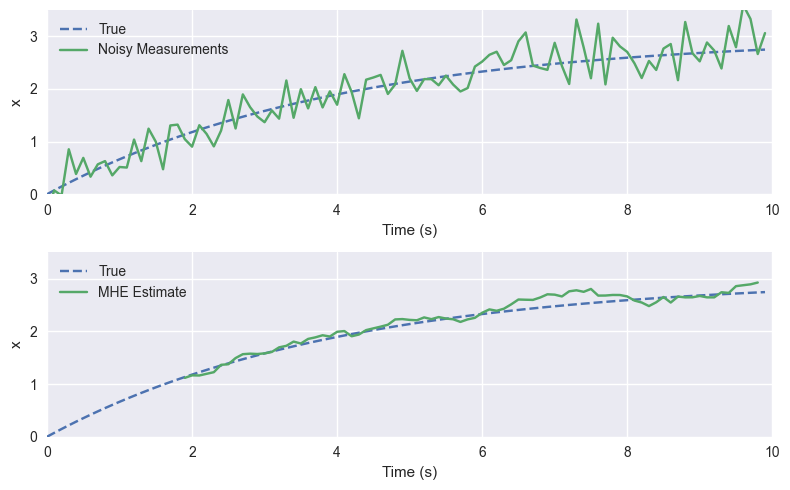

In [3]:
# Plot the results
_, axs = plt.subplots(2, 1, figsize=(8, 5))

# Plot the results
axs[0].plot(ts, xs, label='True', linestyle='--')
axs[0].plot(ts, ys, label='Noisy Measurements')
axs[0].set_xlim([0, 10])
axs[0].set_ylim([0, 3.5])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('x')
axs[0].legend()


axs[1].plot(ts, xs, label='True', linestyle='--')
# axs[1].plot(ts, noisy_xs, label='Noisy Measurements', linestyle='--', alpha=0.7)
axs[1].plot(ts_est, xs_est, label='MHE Estimate')
axs[1].set_xlim([0, 10])
axs[1].set_ylim([0, 3.5])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('x')
axs[1].legend()

plt.tight_layout()
plt.show()